In [142]:
import matplotlib.pylab as plt
import numpy as np
plt.style.use(["science","no-latex", "/afs/ihep.ac.cn/users/l/luoxj/Style/Paper.mplstyle"])
%config InlineBackend.figure_format = 'svg'
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
import sys
from IPython.display import display
sys.path.append("/afs/ihep.ac.cn/users/l/luoxj/root_tool/python_script/")

In [143]:
from LoadMultiFiles import LoadOneFileUproot
dir_map = LoadOneFileUproot("/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/myJUNOCommon/share/tag_event/root/sn_tag_0.root",
                            name_branch="evtTruth", return_list=False)
dir_AP = LoadOneFileUproot("/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/AfterPulsePrediction/root/TagAfterPulse_0.root",
                            name_branch="AfterPulseTag", return_list=False)
dir_PSD = LoadOneFileUproot("/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/myJUNOCommon/share/PSD/root/user_PSD_0_SN.root",
                           name_branch="PSD", return_list=False)
dir_IBD = LoadOneFileUproot("/afs/ihep.ac.cn/users/l/luoxj/PSD_Supernova/code/PromptDelayedSignalSelection/try_0.root",
                            name_branch="IBDSelection", return_list=False)

In [144]:
import seaborn as sns
import pandas as pd
df_AP = pd.DataFrame.from_dict(dir_AP)
df_map = pd.DataFrame.from_dict(dir_map)
df_PSD = pd.DataFrame.from_dict(dir_PSD)
df_PSD = df_PSD.rename({"evtType":"TagPSD"},axis=1)
df_IBD = pd.DataFrame.from_dict(dir_IBD).set_index("evtID")
df_map = pd.concat( (df_map, df_AP, df_PSD, df_IBD),axis=1)
df_map = df_map.sort_values("TriggerTime").reset_index()

R_FV_cut = 17
df_map

,index,evtID,nuE,evtType,recE,recX,recY,recZ,ratioSN,ratioDN,...,entryGen,TotalCharge_lastEvt,TriggerTimeIntervalWithFilter,TotalCharge,TagAP,psdVal,TagPSD,TagIBDp,TagIBDd,IBDSource
0,0,0,19.983615,pES,0.212583,-4925.322266,-2619.566650,3983.017334,0.319780,0.671429,...,6,0.000000,1000.000,744.910091,0,4.332481e-03,2,0,0,-1
1,1,1,72.964650,N12,63.653191,-6283.850098,12852.231445,-4924.565430,0.981472,0.005437,...,7,0.000000,1000.000,113116.718872,0,9.998755e-01,1,0,0,-1
2,2,2,72.964650,AfterPulse,0.482681,139.278885,-23.865454,568.739075,0.028527,0.382421,...,7,113116.718872,1.095,1045.376907,1,5.603862e-03,2,0,0,0
3,3,3,0.000000,AfterPulse,0.311441,81.301765,-534.210999,12.567459,0.000000,0.280500,...,7,113116.718872,3.235,499.848627,1,7.416920e-07,2,0,0,0
4,4,4,12.503522,IBDp,13.340494,4992.425293,10178.103516,4714.770996,0.961626,0.025472,...,13,0.000000,1000.000,22466.255727,0,9.968648e-01,1,1,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18663,18664,18664,13.158622,IBDp,13.805496,-7299.820801,4423.094727,-8364.102539,0.961896,0.024873,...,14092,0.000000,1000.000,22716.439760,0,9.985903e-01,1,1,0,-1
18664,18665,18665,13.158622,IBDd,2.495589,-7529.791504,4455.890137,-8275.335938,0.859468,0.127006,...,14092,0.000000,1000.000,4500.187693,0,9.971751e-01,1,0,1,18664
18665,18666,18666,17.317196,IBDp,18.530066,5044.806152,14350.795898,3421.122070,0.968430,0.018737,...,14093,0.000000,1000.000,33086.969728,0,9.998966e-01,1,1,0,-1
18666,18667,18667,17.317196,IBDd,2.418566,6145.125000,14461.286133,3196.138916,0.861417,0.121205,...,14093,0.000000,1000.000,4655.523785,0,9.983866e-01,1,0,1,18666


## Try to find back detID in pipe up events
* len(detIDs) > 1

In [159]:
df_map_reset_index = df_map.set_index(["fileNo","detID"]).sort_index()
for index, row in df_map[ (df_map["detID"]==-1) & ( (df_map["evtType"]=="IBDd") | (df_map["evtType"]=="IBDp") )].iterrows():
    if len(row["detIDs"]) >0:
        for detID in row["detIDs"]:
            if detID not in df_map_reset_index.loc[ row["fileNo"] ].index:
                continue
            v_evtType = list( df_map_reset_index.loc[ (row["fileNo"],detID) ]["evtType"])
            if ( ("IBDp" in v_evtType) and ("IBDd" in v_evtType) ) or ("IBD" not in "".join(v_evtType) ) :
                continue
            df_map.at[index, "detID"] = np.array( df_map.set_index(["fileNo","detID"]).loc[ (row["fileNo"],detID ) ].index.get_level_values("detID") )[0]
        # break
# display(df_map.loc[101])


# Trigger Time Interval Distribution

In [179]:
from PlotDetectorGeometry import GetR3_XYZ
df_map["R"] = GetR3_XYZ( df_map["recX"],df_map["recY"], df_map["recZ"] )**(1/3)/1e3
df_map["R^3"] = GetR3_XYZ( df_map["recX"],df_map["recY"], df_map["recZ"] )/1e9
df_map["TriggerTime"] /= 1e3
df_map["TriggerTimeInterval"] = np.concatenate( ([0],np.diff( df_map["TriggerTime"] )) )
df_map

,index,evtID,nuE,evtType,recE,recX,recY,recZ,ratioSN,ratioDN,...,TotalCharge,TagAP,psdVal,TagPSD,TagIBDp,TagIBDd,IBDSource,R,TagIBD,R^3
0,0,0,19.983615,pES,0.212583,-4925.322266,-2619.566650,3983.017334,0.319780,0.671429,...,744.910091,0,4.332481e-03,2,0,0,-1,6.854586,Untagged,322.065186
1,1,1,72.964650,N12,63.653191,-6283.850098,12852.231445,-4924.565430,0.981472,0.005437,...,113116.718872,0,9.998755e-01,1,0,0,-1,15.130035,Untagged,3463.536977
2,2,2,72.964650,AfterPulse,0.482681,139.278885,-23.865454,568.739075,0.028527,0.382421,...,1045.376907,1,5.603862e-03,2,0,0,0,0.586031,Untagged,0.201262
3,3,3,0.000000,AfterPulse,0.311441,81.301765,-534.210999,12.567459,0.000000,0.280500,...,499.848627,1,7.416920e-07,2,0,0,0,0.540508,Untagged,0.157909
4,4,4,12.503522,IBDp,13.340494,4992.425293,10178.103516,4714.770996,0.961626,0.025472,...,22466.255727,0,9.968648e-01,1,1,0,-1,12.277914,TagIBDp,1850.860721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18663,18664,18664,13.158622,IBDp,13.805496,-7299.820801,4423.094727,-8364.102539,0.961896,0.024873,...,22716.439760,0,9.985903e-01,1,1,0,-1,11.950287,TagIBDp,1706.612877
18664,18665,18665,13.158622,IBDd,2.495589,-7529.791504,4455.890137,-8275.335938,0.859468,0.127006,...,4500.187693,0,9.971751e-01,1,0,1,18664,12.043002,TagIBDd,1746.643599
18665,18666,18666,17.317196,IBDp,18.530066,5044.806152,14350.795898,3421.122070,0.968430,0.018737,...,33086.969728,0,9.998966e-01,1,1,0,-1,15.591648,TagIBDp,3790.321657
18666,18667,18667,17.317196,IBDd,2.418566,6145.125000,14461.286133,3196.138916,0.861417,0.121205,...,4655.523785,0,9.983866e-01,1,0,1,18666,16.034546,TagIBDd,4122.588568


[]

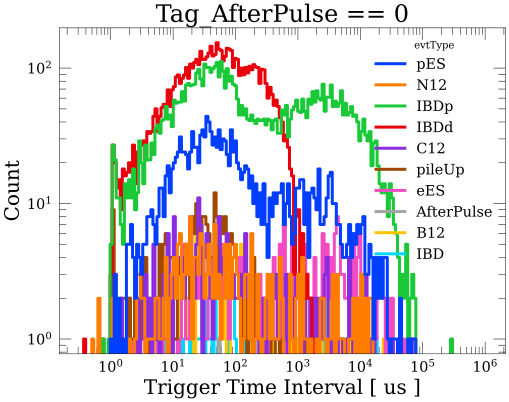

In [147]:
sns.histplot(x="TriggerTimeInterval", data=df_map[df_map["TagAP"]==0], element="step", fill=False,
             bins=np.logspace(-0.5,6, 200), hue="evtType",palette="bright")
plt.xlabel("Trigger Time Interval [ us ]")
plt.title("Tag_AfterPulse == 0")
plt.semilogx()
plt.semilogy()

## Trigger Time Distribution of Different events

[]

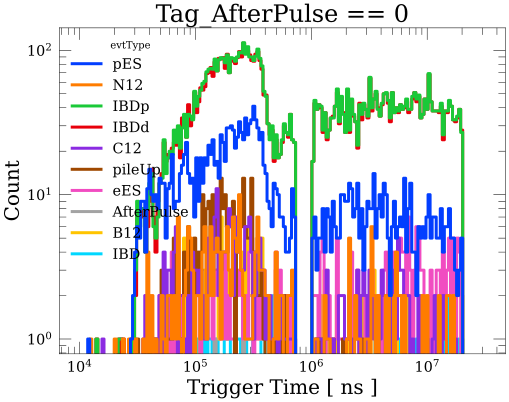

In [158]:
sns.histplot(x="TriggerTime", data=df_map[df_map["TagAP"]==0], element="step", fill=False,
             bins=np.logspace(4,7.5, 200), hue="evtType",palette="bright")
plt.xlabel("Trigger Time [ ns ]")
plt.title("Tag_AfterPulse == 0")
plt.semilogx()
plt.semilogy()

# What do missed IBDs Look like?


In [150]:
display( df_map.groupby([ "TagIBDp","TagIBDd","evtType"]).size() )

TagIBDp  TagIBDd  evtType   
0        0        AfterPulse    2348
                  B12            159
                  C12            283
                  IBD             27
                  IBDd           666
                  IBDp           843
                  N12            247
                  eES            272
                  pES           1783
                  pileUp          78
         1        B12              1
                  IBD             20
                  IBDd          5893
                  IBDp             1
                  pileUp          66
1        0        B12              4
                  C12              2
                  IBD              3
                  IBDd             3
                  IBDp          5840
                  eES              1
                  pES              8
                  pileUp         120
dtype: int64

## 1. Missed IBDd

### Missed IBD Events Distribution

Text(0.5, 0, 'Reconstruct Energy [ MeV ]')

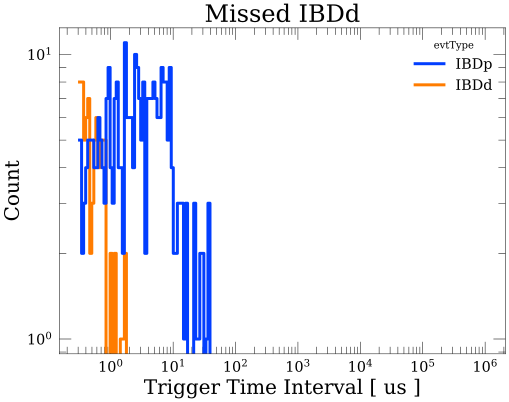

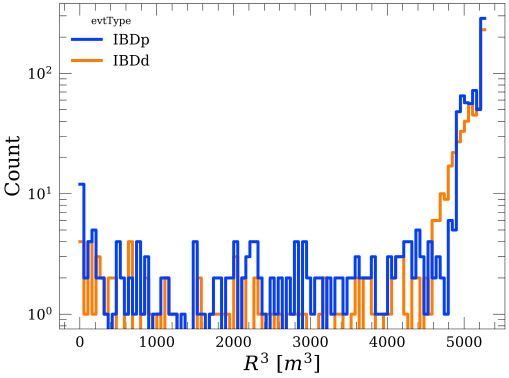

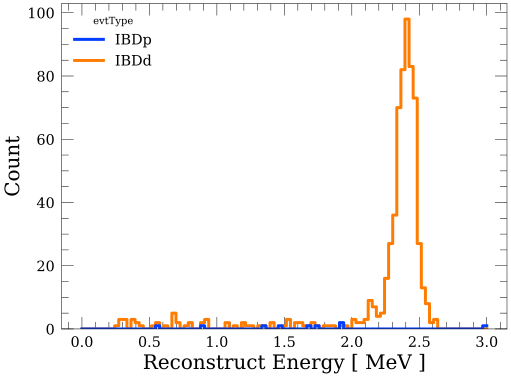

In [182]:
df_map_miss_IBD = df_map[ (df_map["TagAP"]==0) &
                          ( ( (df_map["TagIBDd"]==0) & (df_map["evtType"]=="IBDd") ) |
                            ( (df_map["TagIBDp"]==0) & (df_map["evtType"]=="IBDp") ) ) ]
sns.histplot(x="TriggerTimeInterval",
             data=df_map_miss_IBD,
             element="step", fill=False,
             bins=np.logspace(-0.5,6, 200),
             hue="evtType",palette="bright")
plt.xlabel("Trigger Time Interval [ us ]")
plt.title("Missed IBDd")
plt.semilogx()
plt.semilogy()

plt.figure()
sns.histplot(x="R^3",
             data=df_map_miss_IBD,
             element="step", fill=False,
             hue="evtType",palette="bright",
             bins=100)
plt.xlabel("$R^3$ [$m^3$]")
plt.semilogy()

plt.figure()
sns.histplot(x="recE",
             data=df_map_miss_IBD,
             element="step", fill=False,
             hue="evtType",palette="bright",
             bins=np.linspace(0,3,100))
plt.xlabel("Reconstruct Energy [ MeV ]")

In [183]:
df_map_miss_IBD

,index,evtID,nuE,evtType,recE,recX,recY,recZ,ratioSN,ratioDN,...,TotalCharge,TagAP,psdVal,TagPSD,TagIBDp,TagIBDd,IBDSource,R,TagIBD,R^3
56,56,56,89.302288,IBDp,71.705780,1991.921021,-12704.625000,-8502.834961,0.980464,0.004537,...,127189.436520,0,0.999949,1,0,0,-1,15.416661,Untagged,3664.131069
58,58,58,89.302288,IBDd,0.314270,2152.243652,-12667.941406,-8337.198242,0.627635,0.090415,...,5157.376909,0,0.873374,1,0,0,-1,15.317238,Untagged,3593.696071
92,92,92,27.766304,IBDp,28.201685,12674.250000,11186.786133,-2624.940674,0.974403,0.013158,...,44778.052996,0,0.999743,1,0,0,-1,17.107633,Cut By FV_Cut,5006.909981
93,93,93,27.766304,IBDd,2.255212,12735.795898,11173.712891,-2436.803223,0.850873,0.137064,...,3916.354627,0,0.947049,1,0,0,-1,17.116961,Cut By FV_Cut,5015.104794
99,99,99,34.417025,IBDp,35.622856,-554.976562,-16571.404297,5276.416504,0.975818,0.011862,...,53767.746771,0,0.993357,1,0,0,-1,17.400000,Cut By FV_Cut,5268.024273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18601,18602,18602,9.011824,IBDd,2.453554,10232.079102,256.121216,14041.081055,0.833461,0.151213,...,3969.658337,0,0.853757,1,0,0,-1,17.375644,Cut By FV_Cut,5245.932717
18602,18603,18603,15.297802,IBDp,16.080111,-12057.605469,-6551.522949,10567.710938,0.961730,0.025629,...,24450.447209,0,0.999105,1,0,0,-1,17.320070,Cut By FV_Cut,5195.757963
18603,18604,18604,15.297802,IBDd,2.457168,-12015.146484,-6484.099121,10735.388672,0.836473,0.149209,...,3996.431223,0,0.969071,1,0,0,-1,17.368243,Cut By FV_Cut,5239.232142
18624,18625,18625,26.250244,IBDp,3.969750,10840.101562,4227.817383,-12937.452148,0.890204,0.096811,...,6377.585135,0,0.993561,1,0,0,-1,17.399997,Cut By FV_Cut,5268.021646


In [152]:
from collections import Counter
items_interest = ["evtID","evtType", "recE","TriggerTime", "R", "TriggerTimeInterval", "TagIBDp", "TagIBDd", "IBDSource",
                  "recX", "recY"]
num_index_missed_IBDd  = df_map[ (df_map["TagAP"]==0) & (df_map["TagIBDp"]==0) &
                                 (df_map["evtType"]=="IBDp") & (df_map["detID"]!=-1) &
                                 (df_map["R"]<R_FV_cut) ][ ["fileNo","detID"]  ]
print(len(num_index_missed_IBDd))
df_map_group_by_fileNo = df_map[ (df_map["evtType"]=="IBDp") | (df_map["evtType"]=="IBDd")].set_index(["fileNo", "detID"])
df_missed_IBD = df_map_group_by_fileNo.loc[ num_index_missed_IBDd.itertuples(index=False) ]
df_missed_IBD[ items_interest]

189


evtID evtType       recE   TriggerTime          R  \
fileNo detID                                                      
0      72        56    IBDp  71.705780  3.186277e+04  15.416661   
       72        58    IBDd   0.314270  3.186589e+04  15.317238   
       178      176    IBDp  46.814289  3.818359e+04  10.262223   
       276      305    IBDp  82.465622  4.288660e+04  16.086712   
1      4        586    IBDp  37.383057  5.487083e+04  16.499916   
...             ...     ...        ...           ...        ...   
25     445    17407    IBDp  14.691584  1.116794e+07   6.218808   
       445    17408    IBDd   2.397582  1.116961e+07   5.986529   
26     277    17772    IBDp  12.438278  1.316964e+07  16.405573   
27     449    18497    IBDp   6.685863  1.857075e+07  16.881048   
       449    18498    IBDd   1.357582  1.857077e+07  17.167024   

              TriggerTimeInterval  TagIBDp  TagIBDd  IBDSource          recX  \
fileNo detID                                                                   
0      72                   4.567        0        0         -1   1991.921021   
       72                   1.993        0        0         -1   2152.243652   
       178                 49.503        0        0         -1  -5620.777832   
       276                  6.872        0        0         -1  -5794.425781   
1      4                   43.755        0        0         -1    995.498108   
...                           ...      ...      ...        ...           ...   
25     445               1339.962        0        0         -1    -88.704788   
       445               1667.007        0        0         -1   -128.434937   
26     277              12597.593        0        0         -1  15884.816406   
27     449               5005.527        0        0         -1 -12696.128906   
       449                 17.157        0        0         -1 -12829.713867   

                      recY  
fileNo detID                
0      72    -12704.625000  
       72    -12667.941406  
       178     5164.962891  
       276   -14456.377930  
1      4      -8270.547852  
...                    ...  
25     445    -2717.329590  
       445    -2470.182129  
26     277     2394.866211  
27     449     -911.688232  
       449    -1029.473999  

[283 rows x 11 columns]

In [153]:
df_map.set_index("evtID").loc[1355:1375][items_interest[1:]+["detID"]]

,evtType,recE,TriggerTime,R,TriggerTimeInterval,TagIBDp,TagIBDd,IBDSource,recX,recY,detID
evtID,,,,,,,,,,,
1355,IBDp,12.886560,80101.410,1.341165e+01,7.622,1,0,-1,-5.065704e+03,6.611109e+03,38
1356,pES,4.250796,80135.658,1.340176e+01,34.248,0,0,-1,2.317953e+03,-1.029406e+04,39
1357,IBDd,2.387339,80181.801,1.015858e+01,46.143,0,1,1351,4.648528e+03,-1.820514e+03,36
1358,IBDp,12.984563,80217.963,1.532689e+01,36.162,1,0,-1,5.582823e+03,-8.995612e+03,40
1359,IBDd,2.446456,80269.136,1.543695e+01,51.173,0,1,1358,5.616590e+03,-9.140874e+03,40
1360,IBDp,21.571701,80437.046,1.626350e+01,167.910,0,0,-1,-5.167496e+03,8.385449e+03,42
1361,pES,0.554896,80440.000,3.688491e+00,2.954,0,0,-1,3.260615e+02,5.063388e+02,43
1362,IBDp,8.261173,80444.179,1.286838e+01,4.179,1,0,-1,1.548145e+03,6.020313e+03,44
1363,IBDd,2.417970,80449.167,1.332678e+01,4.988,0,1,1362,1.713220e+03,6.258504e+03,44


/cvmfs/juno.ihep.ac.cn/sw/anaconda/Anaconda3-2020.11-Linux-x86_64/envs/root624/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0, 0.5, 'R [ m ]')

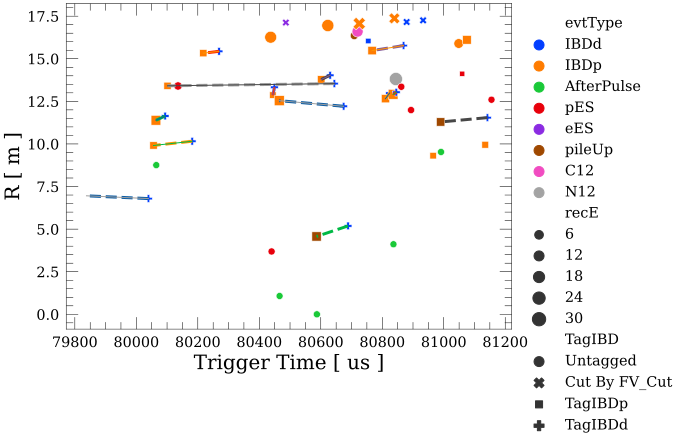

In [162]:
from importlib import reload
import DisplayIBDTimeSeries
reload(DisplayIBDTimeSeries)
from DisplayIBDTimeSeries import PlotTimeSeries
PlotTimeSeries(df_map, 1350,1400, FV_cut=R_FV_cut,key_y_plot="R")
plt.xlabel("Trigger Time [ us ]")
plt.ylabel("R [ m ]")


In [155]:
df_slide = df_map_reset_index.loc[ (df_map.loc[1355:1390]["fileNo"].iloc[2], df_map.loc[1355:1390]["detID"].iloc[2]) ]
df_slide[ df_slide["evtType"] =="IBDp" ]

/tmp/ipykernel_28313/2168385595.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_slide = df_map_reset_index.loc[ (df_map.loc[1355:1390]["fileNo"].iloc[2], df_map.loc[1355:1390]["detID"].iloc[2]) ]


,,index,evtID,nuE,evtType,recE,recX,recY,recZ,ratioSN,ratioDN,...,entryGen,TotalCharge_lastEvt,TriggerTimeIntervalWithFilter,TotalCharge,TagAP,psdVal,TagPSD,TagIBDp,TagIBDd,IBDSource
fileNo,detID,,,,,,,,,,,,,,,,,,,,,
2,50,1369,1369,13.744892,IBDp,14.897916,-7120.392578,-4074.860107,-11075.137695,0.961853,0.02456,...,1050,0.0,1000.0,24926.018286,0,0.999247,1,1,0,-1


191 0.0315702479338843


(array([ 2.,  0.,  0.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  1.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  2.,  1.,  3.,  1.,  2.,  1.,  1.,  1.,  0.,  0.,
         2.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  4.,  0.,  2.,  1.,  1.,
         1.,  2.,  2.,  1.,  2.,  0.,  1.,  1.,  3.,  1.,  2.,  0.,  1.,
         0.,  0.,  4.,  1.,  1.,  1.,  4.,  0.,  4.,  4.,  2.,  5.,  6.,
         3.,  2.,  1.,  3.,  2.,  5.,  4.,  3.,  2.,  4.,  3.,  5.,  5.,
         4.,  4.,  4.,  8.,  8., 10.,  7.,  6., 11.]),
 array([7.68137275e-09, 1.69841090e-01, 3.39682171e-01, 5.09523253e-01,
        6.79364335e-01, 8.49205417e-01, 1.01904650e+00, 1.18888758e+00,
        1.35872866e+00, 1.52856974e+00, 1.69841083e+00, 1.86825191e+00,
        2.03809299e+00, 2.20793407e+00, 2.37777515e+00, 2.54761624e+00,
        2.71745732e+00, 2.88729840e+00, 3.05713948e+00, 3.22698056e+00,
        3.39682164e+00, 3.56666273e+00, 3.73650381e+00, 3.90634489e+00,
  

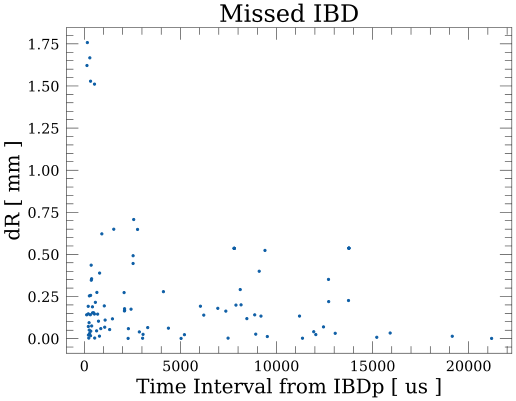

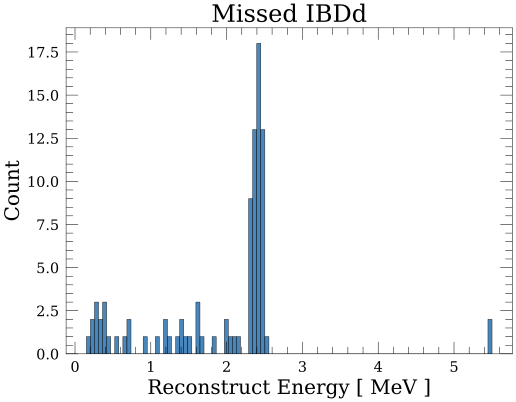

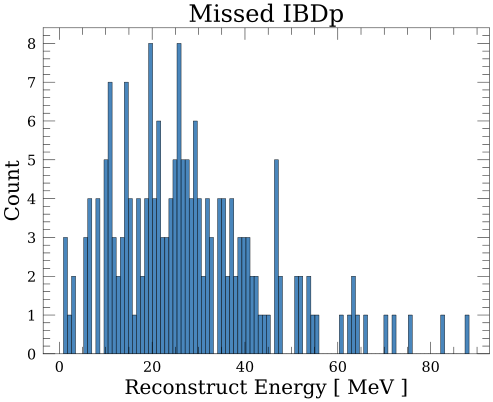

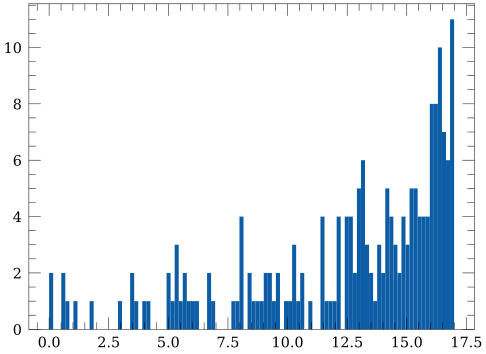

In [156]:
df_missed_IBDd = df_missed_IBD[df_missed_IBD["evtType"]=="IBDd"]
df_missed_IBDp = df_missed_IBD[ ( df_missed_IBD["evtType"]=="IBDp") & (df_missed_IBD["R"]<R_FV_cut)]

print( len( df_missed_IBDp) ,len( df_missed_IBDp)/Counter( (df_map["evtType"]=="IBDp")&(df_map["R"]<R_FV_cut) )[True] )

dt_missed_IBD = ( df_missed_IBDd["TriggerTime"]-df_missed_IBDp["TriggerTime"] )/1e3
dR_missed_IBD = np.sqrt(
                ( df_missed_IBDd["recX"]-df_missed_IBDp["recX"] )**2+\
                ( df_missed_IBDd["recY"]-df_missed_IBDp["recY"] )**2+\
                ( df_missed_IBDd["recZ"]-df_missed_IBDp["recZ"] )**2 )
plt.figure()
plt.scatter( dR_missed_IBD, dt_missed_IBD, s=5)
plt.xlabel("Time Interval from IBDp [ us ]")
plt.ylabel("dR [ mm ]")
plt.title("Missed IBD")

plt.figure()
sns.histplot( df_missed_IBDd["recE"], bins=100 )
plt.title("Missed IBDd")
plt.xlabel("Reconstruct Energy [ MeV ]")

plt.figure()
sns.histplot( df_missed_IBDp["recE"], bins=100 )
plt.title("Missed IBDp")
plt.xlabel("Reconstruct Energy [ MeV ]")

plt.figure()
plt.hist( df_missed_IBDp["R"], bins=100)
